**Table of contents**<a id='toc0_'></a>    
- [Data Mining Lab 2 - Phase 2](#toc1_)    
  - [Before Starting](#toc1_1_)    
  - [Introduction](#toc1_2_)    
  - [**1. Data Preparation**](#toc1_3_)    
  - [**1.1 Load data**](#toc1_4_)    
    - [**1.2 Save data**](#toc1_4_1_)    
  - [**2. Large Language Models (LLMs)**](#toc1_5_)    
    - [Open-Source vs. Proprietary LLMs](#toc1_5_1_)    
    - [Why Use Code (API) for Data Mining?](#toc1_5_2_)    
    - [The Gemini API](#toc1_5_3_)    
    - [Interacting with the Gemini API](#toc1_5_4_)    
    - [**2.1 Text Prompting**](#toc1_5_5_)    
        - [**>>> Exercise 1 (Take home):**](#toc1_5_5_1_1_)    
    - [**2.2 Structured Output**](#toc1_5_6_)    
        - [**>>> Exercise 2 (Take home):**](#toc1_5_6_1_1_)    
    - [**2.3 Information Extraction and Grounding:**](#toc1_5_7_)    
      - [**`langextract`: A Library for Grounded Extraction**](#toc1_5_7_1_)    
        - [**2.3.1 Using PDF Documents:**](#toc1_5_7_1_1_)    
        - [**>>> Bonus Exercise 3 (Take home):**](#toc1_5_7_1_2_)    
    - [**2.4 Generating LLM Embeddings:**](#toc1_5_8_)    
        - [**>>> Exercise 4 (Take home):**](#toc1_5_8_1_1_)    
    - [**2.5 Retrieval-Augmented Generation (RAG)**](#toc1_5_9_)    
        - [**Actual answer in the URL:**](#toc1_5_9_1_1_)    
        - [**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc1_5_9_1_2_)    
        - [**>>> Bonus Exercise 5 (Take home):**](#toc1_5_9_1_3_)    
    - [**2.6 Few-Shot Prompting Classification:**](#toc1_5_10_)    
        - [**>>> Exercise 6 (Take home):**](#toc1_5_10_1_1_)    
        - [**>>> Exercise 7 (Take home):**](#toc1_5_10_1_2_)    
    - [**2.7 Extra LLM Related Materials:**](#toc1_5_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Data Mining Lab 2 - Phase 2](#toc0_)
In this lab's phase 2 session we will focus on exploring some basic LLMs' applications with data.


## <a id='toc1_1_'></a>[Before Starting](#toc0_)

**Make sure you have installed all the required libraries and you have the environment ready to run this lab.**
    

---
## <a id='toc1_2_'></a>[Introduction](#toc0_)

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embeddings and other deep information retrieval approaches.

![pic0.png](./pics/pic0.png)

---
## <a id='toc1_3_'></a>[**1. Data Preparation**](#toc0_)

---
## <a id='toc1_4_'></a>[**1.1 Load data**](#toc0_)

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [2]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [3]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("cuda version (runtime):", torch.version.cuda)

torch: 2.1.2
cuda available: True
cuda device count: 1
cuda version (runtime): 12.1


In [4]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [5]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [6]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [7]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### <a id='toc1_4_1_'></a>[**1.2 Save data**](#toc0_)

In [8]:
# save to pickle file
train_df.to_pickle("./data/train_df.pkl") 
test_df.to_pickle("./data/test_df.pkl")

In [9]:
import pandas as pd

# load a pickle file
train_df = pd.read_pickle("./data/train_df.pkl")
test_df = pd.read_pickle("./data/test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
## <a id='toc1_5_'></a>[**2. Large Language Models (LLMs)**](#toc0_)

Before we start we strongly suggest that you watch the following video explanations so you can understand the concepts that we are gonna discuss about LLMs: 

1. [How Large Language Models Work](https://www.youtube.com/watch?v=5sLYAQS9sWQ)
2. [Large Language Models explained briefly](https://www.youtube.com/watch?v=LPZh9BOjkQs)
3. [What is Prompt Tuning?](https://www.youtube.com/watch?v=yu27PWzJI_Y)
4. [Why Large Language Models Hallucinate](https://www.youtube.com/watch?v=cfqtFvWOfg0)
5. [What are LLM Embeddings?](https://www.youtube.com/watch?v=UShw_1NbpCw&t=182s)
6. [What is Retrieval-Augmented Generation (RAG)?](https://www.youtube.com/watch?v=T-D1OfcDW1M)
7. [RAG vs Fine-Tuning vs Prompt Engineering: Optimizing AI Models](https://www.youtube.com/watch?v=zYGDpG-pTho)
8. [Discover Few-Shot Prompting | Google AI Essentials](https://www.youtube.com/watch?v=9qdgEBVkWR4)
9. [What is Zero-Shot Learning?](https://www.youtube.com/watch?v=pVpr4GYLzAo)
10. [Zero-shot, One-shot and Few-shot Prompting Explained | Prompt Engineering 101](https://www.youtube.com/watch?v=sW5xoicq5TY)

`These videos can help you get a better grasp on the core concepts of LLMs if you were not familiar before.`

**So now let's start with the main content of Lab 2 Phase 2.**

Large Language Models (LLMs) are AI systems trained on vast amounts of text to understand and generate human language for tasks like summarization and translation.

### <a id='toc1_5_1_'></a>[Open-Source vs. Proprietary LLMs](#toc0_)
*   **Open-Source Models** (e.g., Llama, Gemma) are customizable and cost-effective but require technical skill to manage and may be less powerful.
*   **Proprietary Models** (e.g., Gemini, ChatGPT) offer top performance and ease of use but are more costly and less flexible.

For students interested in running models locally, the optional notebook `DM2025-Lab2-Optional-Ollama.ipynb` explores using Ollama ([Ollama GitHub Link](https://github.com/ollama/ollama)). It needs a capable GPU to run models (**at least 4GB VRAM**).

You can explore the variety of models available through Ollama here:

![pic10.png](./pics/pic10.png)

### <a id='toc1_5_2_'></a>[Why Use Code (API) for Data Mining?](#toc0_)

For data analysis, accessing LLMs programmatically is superior to using web chatbots because it allows for:
*   **Automation:** Easily process entire datasets with loops.
*   **Structured Output:** Receive data in usable formats like **JSON**, ready for analysis in tools like pandas.
*   **Reproducibility:** Ensure consistent results by setting fixed parameters.
*   **Privacy:** Maintain data security, especially when running models locally.

For the main exercises in this lab, we will use **the Gemini API**. This approach offers several advantages over running local open-source models, such as access to state-of-the-art model performance without needing specialized hardware. While the API has usage limits (rate limits and token quotas), it provides a generous **free tier** that is more than sufficient for our exercises.

![pic13.png](./pics/pic13.png)

![pic14.png](./pics/pic14.png)

### <a id='toc1_5_3_'></a>[The Gemini API](#toc0_)

We will primarily use the **Gemini 2.5 Flash-Lite** (`gemini-2.5-flash-lite`) model. As shown in the rate limit table, this model is optimized for high-frequency tasks and offers a high request-per-day limit of 1,000, making it ideal for completing the lab exercises without interruption.

Students are encouraged to explore other models available through the API but should remain mindful of their respective usage limits. For instance:
*   **Gemini 2.5 Pro** is a more powerful model but has a lower daily request limit of 100.
*   The **Gemma 3** model available via the API offers an impressive 14,400 requests per day, providing another excellent alternative for experimentation.

Please be aware of your usage limits as you work through the exercises to ensure you do not get rate-limited.

[Gemini Documentation](https://ai.google.dev/gemini-api/docs)

[Gemini Rate Limits](https://ai.google.dev/gemini-api/docs/rate-limits)

[Description of Gemini Models](https://ai.google.dev/gemini-api/docs/models)

---

### <a id='toc1_5_4_'></a>[Interacting with the Gemini API](#toc0_)

The code cell below contains the primary function, `prompt_gemini`, that we will use throughout this lab to communicate with the Gemini API. It's designed to be a flexible wrapper that handles the details of sending a request and receiving a response.

Before you run the exercises, here are the key things you need to understand in this setup:

*   **API Key Configuration**: The script loads your API key from a `.env` file located in the `./config/` directory. **You must create this file and add your API key** like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`. This is a security best practice to keep your credentials out of the code.

*   **Global Settings**: At the top of the script, you can find and modify several important defaults:
    *   `MODEL_NAME`: We've set this to `"gemini-2.5-flash-lite"`, but you can easily switch to other models like `"gemini-2.5-pro"` to experiment.
    *   `SYSTEM_INSTRUCTION`: This sets the model's default behavior or persona (e.g., "You are a helpful assistant"). You can customize this for different tasks.
    *   `SAFETY_SETTINGS`: For our academic exercises, these are turned off to prevent interference. In real-world applications, you would configure these carefully.

*   **The `prompt_gemini` function**: This is the main tool you will use. Here are its most important parameters:
    *   `input_prompt`: The list of contents (text, images, etc.) you want to send to the model.
    *   `temperature`: Controls the randomness of the output. `0.0` makes the output deterministic and less creative, while a higher value (e.g., `0.7`) makes it more varied.
    *   `schema`: A powerful feature that allows you to specify a JSON format for the model's output. This is extremely useful for structured data extraction.
    *   `with_tokens_info`: If set to `True`, the function will also return the number of input and output tokens used, which is helpful for monitoring your usage against the free tier limits.

In the following exercises, you will call this function with different prompts and configurations to solve various tasks.

If needed, you can also check some tutorials on how a python function works: [Python Functions Tutorial](https://realpython.com/defining-your-own-python-function/)

In [10]:
import os
from dotenv import load_dotenv
from google import genai
from google.genai import types

env_path = "./config/.env"
load_dotenv(dotenv_path=env_path)

# System instruction that can dictate how the model behaves in the output, can be customized as needed
SYSTEM_INSTRUCTION = (
        "You are a helpful assistant"
    )

# Max amount of tokens that the model can output, the Gemini 2.5 Models have this maximum amount
# For other models need to check their documentation 
MAX_OUTPUT_TOKENS = 65535
MODEL_NAME = "gemini-2.5-flash-lite" # Other models: "gemini-2.5-pro", "gemini-2.5-flash"; Check different max output tokens: "gemini-2.0-flash" , "gemini-2.0-flash-lite" 

# We disable the safety settings, as no moderation is needed in our tasks
SAFETY_SETTINGS = [
    types.SafetySetting(
        category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_HARASSMENT", threshold="OFF")
]

#IMPORTANT: The script loads your API key from a `.env` file located in the `./config/` directory. 
# You must create this file and add your API key like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`

# We input the API Key to be able to use the Gemini models
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key
client = genai.Client(api_key=api_key)

# We also set LangExtract to use the API key as well:
if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = api_key

def prompt_gemini(
        input_prompt: list,
        schema = None,
        temperature: float = 0.0,
        system_instruction: str = SYSTEM_INSTRUCTION,
        max_output_tokens: int = MAX_OUTPUT_TOKENS,
        client: genai.Client = client,
        model_name: str = MODEL_NAME,
        new_config: types.GenerateContentConfig = None,
        with_tools: bool = False,
        with_parts: bool = False,
        with_tokens_info: bool = False
    ):
        try:
            # If we need a JSON schema we set up the following
            if schema:
                generate_content_config = types.GenerateContentConfig(
                    temperature=temperature,
                    system_instruction=system_instruction,
                    max_output_tokens=max_output_tokens,
                    response_modalities=["TEXT"],
                    response_mime_type="application/json",
                    response_schema=schema,
                    safety_settings=SAFETY_SETTINGS
                )
            # If there is no need we leave it unstructured
            else:
                generate_content_config = types.GenerateContentConfig(
                    temperature=temperature,
                    system_instruction=system_instruction,
                    max_output_tokens=max_output_tokens,
                    response_modalities=["TEXT"],
                    safety_settings=SAFETY_SETTINGS
                )
            
            # We add a different custom configuration if we need it
            if new_config:
                generate_content_config = new_config
            
            # For some tasks we need a more specific way to add the contents when prompting the model
            # So we need custom parts for it sometimes from the "types" objects
            if with_parts:
                response = client.models.generate_content(
                    model=model_name,
                    contents=types.Content(parts=input_prompt),
                    config=generate_content_config,
                )
            # In the simplest form the contents can be expressed as a list [] of simple objects like str and Pillow images
            else:
                response = client.models.generate_content(
                    model=model_name,
                    contents=input_prompt,
                    config=generate_content_config,
                )

            if with_tools:
                # print(response)
                # Include raw response when function calling
                completion = response
                if with_tokens_info:
                    log = {
                        "model": model_name,
                        "input_tokens": response.usage_metadata.prompt_token_count,
                        "output_tokens": response.usage_metadata.candidates_token_count,
                    }
                    return completion, log
                return completion
            else:
                completion = response.text
                if with_tokens_info:
                    log = {
                        "model": model_name,
                        "input_tokens": response.usage_metadata.prompt_token_count,
                        "output_tokens": response.usage_metadata.candidates_token_count,
                    }
                    # Return the text response and logs (if selected)
                    return completion, log
                return completion
        except Exception as e:
             print(f"Error occurred when generating response, error: {e}")
             return None

---
### <a id='toc1_5_5_'></a>[**2.1 Text Prompting**](#toc0_)

In the same way as with ChatGPT we can use the Gemini models to ask about anything. Here we are going to ask a question requesting the response to be in markdown format, this is to make it have a better display afterwards.

For more information visit:
[Gemini's Text Generation Documentation](https://ai.google.dev/gemini-api/docs/text-generation)

In [11]:
input_prompt = ["What is Data Mining?"]
text_response, logs = prompt_gemini(input_prompt = input_prompt, with_tokens_info = True)
print(text_response)

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strat

We can also check the logs of the usage with our model that we defined in our previous function. We can observe the model we used, how many tokens where in the prompt in the input, and the output text response tokens of our model.

In [12]:
print(logs)

{'model': 'gemini-2.5-flash-lite', 'input_tokens': 12, 'output_tokens': 911}


**We can use the IPython library to make the response look better:**

In [13]:
from IPython.display import display, Markdown
display(Markdown(text_response))

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strategic planning.

**How it Works (The Process):**

Data mining is usually an iterative process that involves several stages:

1.  **Business Understanding:** Defining the problem or objective you want to achieve with data mining. What questions are you trying to answer? What business goals are you trying to meet?
2.  **Data Understanding:** Exploring and getting familiar with the data. This involves collecting, cleaning, and understanding the data's structure, quality, and meaning.
3.  **Data Preparation (Preprocessing):** This is often the most time-consuming stage. It involves:
    *   **Cleaning:** Handling missing values, noisy data, and inconsistencies.
    *   **Integration:** Combining data from multiple sources.
    *   **Transformation:** Normalizing or aggregating data to make it suitable for mining.
    *   **Reduction:** Reducing the size of the dataset while preserving important information.
4.  **Modeling:** Selecting and applying appropriate data mining techniques (algorithms) to discover patterns. This is where the "mining" happens.
5.  **Evaluation:** Assessing the quality and usefulness of the discovered patterns. Do they make sense? Are they statistically significant? Do they meet the business objectives?
6.  **Deployment:** Putting the discovered knowledge into practice. This could involve integrating it into business processes, creating reports, or building predictive models.

**Common Data Mining Techniques:**

Data mining employs a variety of techniques, often drawing from statistics, machine learning, and database systems. Some of the most common include:

*   **Classification:** Categorizing data into predefined classes (e.g., predicting whether a customer will churn or not).
*   **Clustering:** Grouping similar data points together without predefined classes (e.g., segmenting customers into different groups based on their purchasing behavior).
*   **Association Rule Mining:** Discovering relationships between items in a dataset (e.g., "customers who buy bread also tend to buy milk"). This is often used in market basket analysis.
*   **Regression:** Predicting a continuous numerical value (e.g., predicting the price of a house based on its features).
*   **Anomaly Detection (Outlier Detection):** Identifying data points that deviate significantly from the norm (e.g., detecting fraudulent transactions).
*   **Sequential Pattern Mining:** Discovering patterns that occur in a sequence over time (e.g., identifying common user navigation paths on a website).

**Why is Data Mining Important?**

Data mining is crucial for businesses and organizations because it enables them to:

*   **Make Better Decisions:** By understanding customer behavior, market trends, and operational efficiencies, organizations can make more informed and strategic decisions.
*   **Improve Customer Relationships:** Identifying customer preferences and predicting their needs allows for personalized marketing, better customer service, and increased loyalty.
*   **Detect Fraud and Risk:** Anomaly detection can help identify fraudulent activities, security breaches, and potential risks.
*   **Optimize Operations:** Understanding patterns in operational data can lead to improved efficiency, reduced costs, and better resource allocation.
*   **Drive Innovation:** Discovering new insights can spark new product development, service offerings, and business models.
*   **Gain a Competitive Advantage:** Organizations that effectively leverage data mining can outperform their competitors by understanding their market and customers better.

In essence, data mining is a powerful tool for transforming raw data into valuable intelligence, driving progress and innovation across various fields.

---
##### <a id='toc1_5_5_1_1_'></a>[**>>> Exercise 1 (Take home):**](#toc0_)

`With your own prompt`, run the previous example in the following way:

1. Run it with the same model as the example (gemini-2.5-flash-lite). 
2. Run it with a different gemini model from the available options for the API.
3. Discuss the differences on the results with different models.
4. Discuss what would happen if you change the system prompt.


In [14]:
input_prompt = ["How many calories in a donut?"]
text_response, logs = prompt_gemini(input_prompt = input_prompt, with_tokens_info = True)
display(Markdown(text_response))

input_prompt = ["How many calories in a donut?"]
text_response, logs = prompt_gemini(input_prompt = input_prompt, with_tokens_info = True, model_name="gemini-2.5-pro")
display(Markdown(text_response))

The number of calories in a donut can vary **significantly** depending on several factors:

*   **Type of donut:** This is the biggest factor.
    *   **Plain cake donut:** Generally the lowest in calories.
    *   **Glazed donut:** Adds sugar and calories.
    *   **Jelly-filled donut:** The filling adds calories.
    *   **Cream-filled donut:** Cream fillings are often high in fat and sugar, making these calorie-dense.
    *   **Frosted/Iced donuts:** The frosting or icing adds a substantial amount of sugar and calories.
    *   **Specialty donuts:** Donuts with toppings like sprinkles, nuts, candy pieces, or drizzles will have even more calories.
*   **Size of the donut:** A mini donut will have fewer calories than a large, gourmet donut.
*   **Ingredients and preparation:** Different recipes will use varying amounts of sugar, fat, and other ingredients.

**Here's a general range to give you an idea:**

*   **Plain Cake Donut:** Around **200-250 calories**
*   **Glazed Donut:** Around **250-300 calories**
*   **Jelly-Filled Donut:** Around **250-350 calories**
*   **Cream-Filled Donut:** Around **300-450 calories**
*   **Frosted/Iced Donut:** Around **300-400 calories**
*   **Specialty/Gourmet Donuts:** Can easily range from **400 to 600+ calories**

**To get the most accurate calorie count, you should:**

*   **Check the packaging:** If you buy donuts from a store, the nutritional information is often available on the packaging or on the store's website.
*   **Look up specific brands/types:** If you know the brand and type of donut, you can often find calorie information online.
*   **Use a calorie-tracking app:** Many apps have extensive databases of food items, including various types of donuts.

**In summary, a typical donut can range from about 200 to over 600 calories. It's best to be specific about the type and size for a more precise answer.**

That's a great question! The number of calories in a donut can vary dramatically depending on its size, ingredients, toppings, and whether it's filled.

Here’s a general breakdown from the simplest to the most indulgent.

### Quick Answer: The General Range

A typical, medium-sized donut falls somewhere in the **250 to 350 calorie** range. However, they can be as low as 190 or as high as 500+ calories.

---

### Calorie Breakdown by Donut Type

Here are some common examples to give you a better idea:

#### 1. Simple & Classic Donuts
*   **Classic Glazed Donut:** **190 - 260 calories**. This is your baseline. A Krispy Kreme Original Glazed is on the lower end (190), while a Dunkin' Glazed Donut is higher (260).
*   **Plain Cake Donut:** **230 - 300 calories**. Cake donuts are denser and tend to absorb more oil when fried.
*   **Sugar Donut:** **210 - 250 calories**.

#### 2. Frosted & Topped Donuts
*   **Chocolate Frosted Donut:** **280 - 370 calories**. The frosting adds a significant amount of sugar and fat.
*   **Donut with Sprinkles (e.g., Strawberry Frosted):** **290 - 350 calories**.
*   **Old Fashioned Donut (Glazed):** **280 - 420 calories**. These are often very dense and rich.

#### 3. Filled Donuts
*   **Jelly-Filled Donut (Bismarck):** **280 - 340 calories**. The jelly is mostly sugar.
*   **Cream or Custard-Filled (Boston Kreme):** **300 - 400 calories**. The creamy filling adds more fat and sugar than jelly.

#### 4. Fancy & Specialty Donuts
*   **Apple Fritter:** **400 - 500 calories**. These are large, dense, and have a lot of glaze.
*   **Cruller (Glazed):** **240 - 300 calories**. They are lighter and airier than cake donuts.
*   **Gourmet Donut (e.g., Maple Bacon, Peanut Butter Cup):** **350 - 550+ calories**. These are often the highest in calories due to rich toppings and fillings.

---

### Examples from Popular Chains

To make it more concrete, here are a few popular items:

**Dunkin'**
*   Glazed Donut: **260 calories**
*   Boston Kreme Donut: **300 calories**
*   Chocolate Frosted with Sprinkles: **300 calories**
*   Glazed Chocolate Cake Donut: **370 calories**

**Krispy Kreme**
*   Original Glazed® Doughnut: **190 calories**
*   Chocolate Iced Glazed Doughnut: **240 calories**
*   Glazed Raspberry Filled Doughnut: **290 calories**
*   Cake Batter Doughnut: **350 calories**

### Key Takeaway

For a rough estimate, remember:
*   A **simple glazed donut** is your lowest-calorie option, usually around **200-250 calories**.
*   Adding **frosting, fillings, or heavy toppings** can easily push a donut into the **300-500 calorie** range.

### ANSWER:

We see that the Pro Gemini Version has much longer text, going into details and structuring the text nicely, with a table. Lite is more generalized, while Pro goes into detail and gives ranges as answers. Lite gives a more concise answer, while Pro's answer is more conversational

---
### <a id='toc1_5_6_'></a>[**2.2 Structured Output**](#toc0_)

By default, an LLM responds with unstructured, free-form text. For data mining, this is often impractical, as we need data in a predictable format to load into tools like a pandas DataFrame for analysis. **Structured output** is a powerful feature that forces the model to return its response in a specific, machine-readable format, such as JSON.

The key to enabling this is to provide the model with a **response schema**. This schema acts as a strict template or blueprint that the model's output must conform to. Instead of generating a paragraph, the model will fill in the fields defined in your schema with the relevant information it extracts from the prompt.

In the following code, we define this schema using Python classes. Think of each class as defining a JSON object:
*   The **attributes** of the class (e.g., `topic_name`, `sub_title`) become the keys in the final JSON object.
*   The **type hints** for those attributes (e.g., `str`, `list`) tell the model what kind of data is expected for each key's value.

We can even nest these classes inside one another to create complex, hierarchical JSON structures. This allows us to precisely control the format of the output, transforming the LLM from a simple text generator into a reliable tool for automated and structured data extraction.

[Gemini's Structured Output Documentation](https://ai.google.dev/gemini-api/docs/structured-output)

For data validation of schemas Gemini API uses the Pydantic library, for more documentation on it you can check: [Pydantic](https://docs.pydantic.dev/latest/) 

[JSON Format Documentation](https://docs.python.org/3/library/json.html)

In [15]:
from pydantic import BaseModel

# We define our structure schema that Gemini should follow for the output response

# Subsections on the topics we query
class Subsection(BaseModel):
    sub_title: str
    sub_explanation: str

# The top-level structure for the entire topic analysis
class Topic(BaseModel):
    topic_name: str
    subsections: list[Subsection]

In [16]:
input_prompt = ["Explain what are machine learning, data centers, llms and how do they relate to each other."]
text_response = prompt_gemini(input_prompt = input_prompt, schema = list[Topic])
print(text_response)

[
  {
    "topic_name": "Machine Learning",
    "subsections": [
      {
        "sub_title": "Definition",
        "sub_explanation": "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."
      },
      {
        "sub_title": "Types of Machine Learning",
        "sub_explanation": "Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties)."
      },
      {
        "sub_title": "Applications",
        "sub_explanation": "ML is used in a wide range of applications, such as image recognition, natural language processing, recommend

In [17]:
import json

# Now the response can be parsed to a python object using the JSON dictionary structure loading
structured_resp = json.loads(text_response)
print(structured_resp)
print(type(structured_resp))

[{'topic_name': 'Machine Learning', 'subsections': [{'sub_title': 'Definition', 'sub_explanation': "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."}, {'sub_title': 'Types of Machine Learning', 'sub_explanation': 'Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties).'}, {'sub_title': 'Applications', 'sub_explanation': 'ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis.'}]}, {'topic_name': 'Data Centers', 'subs

In [18]:
# So now we have an object that we can explore/use in a pythonic way for our purposes
for topic in structured_resp:
    print(topic["topic_name"], "\n")
    # We can access each subsection as well
    for subsection in topic["subsections"]:
        print("\t", subsection["sub_title"], "\n")
        print("\t\t", subsection["sub_explanation"], "\n")


Machine Learning 

	 Definition 

		 Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention. 

	 Types of Machine Learning 

		 Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties). 

	 Applications 

		 ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis. 

Data Centers 

	 Definition 

		 A data center is a dedicated physical facility that an organization uses to house its critical IT infrastructure, including servers

##### <a id='toc1_5_6_1_1_'></a>[**>>> Exercise 2 (Take home):**](#toc0_)

Try a prompt with your own schema structure, it needs to be completely different to the example. It should show an intuitive way to represent the text output of the model based on the prompt you chose. See the documentation for reference: https://ai.google.dev/gemini-api/docs/structured-output

In [19]:
schema1 = {
  "type": "object",
  "properties": {
    "food_name": {"type": "string"},
    "serving_size_g": {"type": "number"},
    "calories": {"type": "number"},
    "protein_g": {"type": "number"},
    "fat_g": {"type": "number"},
    "carbohydrates_g": {"type": "number"}
  },
  "required": ["food_name", "calories"]
}

input_prompt = ["Give me the nutritional values of the most popular donut in this schema:"]
text_response = prompt_gemini(input_prompt = input_prompt, schema = schema1)
print(text_response)

{
  "food_name": "Glazed Donut",
  "serving_size_g": 40.0,
  "calories": 190.0,
  "protein_g": 2.0,
  "fat_g": 10.0,
  "carbohydrates_g": 24.0
}


---
### <a id='toc1_5_7_'></a>[**2.3 Information Extraction and Grounding:**](#toc0_)

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

When using LLMs to extract structured data from text, two main challenges arise:

1.  **Trust:** LLMs can "hallucinate" or invent information. We need to ensure the extracted data is accurate and comes directly from the source text.
2.  **Scalability:** We need a reliable way to extract complex information consistently from thousands of large, messy documents.

The solution to these challenges is **grounding**—the process of linking every piece of extracted data back to its specific origin in the source document. This creates a verifiable audit trail, building trust in the output.

---
#### <a id='toc1_5_7_1_'></a>[**`langextract`: A Library for Grounded Extraction**](#toc0_)

**`langextract`** is an open-source Python library from Google designed to create trustworthy data extraction pipelines. It uses LLMs to convert unstructured text into structured data with a focus on reliability and traceability.

**Key Features:**

*   **Precise Grounding:** Its core feature. It maps every extracted item to its exact character position in the original text, allowing for easy verification.
*   **Reliable Structured Output:** Uses examples (few-shot prompting) to ensure the LLM's output consistently follows a predefined format.
*   **Adaptable & No Fine-Tuning:** Can be adapted to any domain (e.g., legal, medical) simply by changing the examples and instructions, without needing to retrain a model.
*   **Handles Long Documents:** Built to process lengthy texts that might exceed an LLM's standard context window.
*   **Flexible LLM Support:** It is model-agnostic and works with various LLMs like Gemini, OpenAI models, and even local open-source models through Ollama.

**`Github repository:`** [langextract](https://github.com/google/langextract)

---

##### <a id='toc1_5_7_1_1_'></a>[**2.3.1 Using PDF Documents:**](#toc0_)

For PDF Document information extraction we are going to use the `pymupdf` library. Documentation: [pymupdf](https://pymupdf.readthedocs.io/en/latest/)

And then we are going to pass it on to langextract to get insights on the document's content.

We can also process documents using Gemini, for more information you can check their documentation: [Document Understanding](https://ai.google.dev/gemini-api/docs/document-processing)

In [20]:
import pymupdf
# Extract text from the PDF and format it for the prompt
# This is a review from the movie interstellar
pdf_path = "./data/documents/doc_example_review_interstellar.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    # In case the PDF documents have more than one page, in this example it only has one
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text += f'**Page {i + 1}**\n'
        formatted_text += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

✓ Extracted text from './data/documents/doc_example_review_interstellar.pdf'


In [21]:
print(formatted_text)

**Page 1**
"""
Dan Baldwin
Group 4
Auteur Review - Interstellar 
I believe Christopher Nolan: the director behind the 2014 sci-ﬁ/adventure cinematic ‘Interstellar,’ 
to be a very intellectual and imaginative inventive talent.  
His style in his previous ﬁlms sets characters in epic unique locations, with gargantuan issues to 
face, and artistically impresses the audience with how the characters solve their problems. For 
example, in Nolan’s 2010 ﬁlm ‘Inception,’ he tackles the idea of dreams, and sets his characters 
diving through dreams within dreams within even more dreams to complete their goals. Because 
this idea is so farfetched, and dreams are a subject in which science has made little factual 
discovery in, Nolan is free to use his creativity to present ideas such as landscapes folding in on 
themselves and corridors spinning, without seeming unrealistic. 
This brain-racking epic theme is once again evident in ‘Interstellar,’ as Nolan sets his characters 
during a second Ameri

We define our prompt and examples based on our required type of data, in this case we are going to do it having `movie reviews` in mind.

In [22]:
import langextract as lx
import textwrap

# Defining the extraction prompt for "movie review" type of data
prompt = textwrap.dedent("""\
    Extract specific opinions and their impact on the audience from this movie review.
    Important: Use exact text verbatim from the input for extraction_text. Do not paraphrase.
    Extract entities in order of appearance with no overlapping text spans.

    Use the 'opinion_statement' class for direct judgments about film elements (like plot, score, or acting).
    - 'subject' should be the element being reviewed.
    - 'sentiment' should be Positive, Negative, or Neutral.
    - 'key_phrase' should be the core descriptive words.

    Use the 'audience_impact' class for phrases describing the effect on the viewer.
    - 'emotion_evoked' should be the feeling or reaction (e.g., stress, joy, confusion).
    - 'causal_element' is what part of the film caused the reaction.
    - 'target_audience' is who was affected (e.g., 'the audience', 'the reviewer').
    """)

# Providing high-quality examples to guide the model
# These examples show the model exactly how to differentiate between the two classes
examples = [
    # Example 1: Demonstrates a positive opinion on the plot and its direct impact on the reviewer
    lx.data.ExampleData(
        text="The film boasts a truly clever plot that kept me guessing until the very end.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="a truly clever plot",
                attributes={
                    "subject": "The plot",
                    "sentiment": "Positive",
                    "key_phrase": "truly clever"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="kept me guessing until the very end",
                attributes={
                    "emotion_evoked": ["engaged", "curious"],
                    "causal_element": "The plot",
                    "target_audience": "the reviewer"
                }
            ),
        ]
    ),
    # Example 2: Shows a negative opinion and a separate audience impact caused by the soundtrack
    lx.data.ExampleData(
        text="Unfortunately, the dialogue felt clunky and unnatural, and the jarring soundtrack made the audience jump.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="the dialogue felt clunky and unnatural",
                attributes={
                    "subject": "The dialogue",
                    "sentiment": "Negative",
                    "key_phrase": "clunky and unnatural"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="made the audience jump",
                attributes={
                    "emotion_evoked": ["startled", "on edge"],
                    "causal_element": "The soundtrack",
                    "target_audience": "the audience"
                }
            )
        ]
    )
]

Here we define our main function to call for langextract information extraction, note that there are some constants in the functions that we are not going to change for the example but it would be required to explore and understand in the exercise. In this function we obtain the resulting raw extracted information into a .jsonl file and the visualization into a .html file. Check the documentation for more information.

The files will be saved in the following directory: `results/info_extractions`

In [23]:
import os
import langextract as lx

# We define our main langextract function 
def grounded_info_extraction(input_documents, prompt, examples, file_name, model_id ="gemini-2.5-flash-lite", extraction_passes = 1, max_workers = 5, max_char_buffer = 2000):
    result = lx.extract(
        text_or_documents=input_documents,
        prompt_description=prompt,
        examples=examples,
        model_id=model_id,
        extraction_passes=extraction_passes,    # Improves recall through multiple passes over the same text, needs temperature above 0.0
        max_workers=max_workers,         # Parallel processing for speed, remember there are API call rate limits, so do not abuse
        max_char_buffer=max_char_buffer    # Smaller contexts for better accuracy, currently: 1000 characters per batch
    )

    # Display results
    print(f"Extracted {len(result.extractions)} entities:\n")
    for extraction in result.extractions:
        print(f"• {extraction.extraction_class}: '{extraction.extraction_text}'")
        if extraction.attributes:
            for key, value in extraction.attributes.items():
                print(f"  - {key}: {value}")
    
    output_dir = "./results/info_extractions"
    os.makedirs(output_dir, exist_ok=True)
    # Save results to JSONL
    lx.io.save_annotated_documents([result], output_name=f"{file_name}.jsonl", output_dir=output_dir)

    # Generate interactive visualization
    html_content = lx.visualize(f"{output_dir}/{file_name}.jsonl")
    with open(f"{output_dir}/{file_name}_vis.html", "w") as f:
        if hasattr(html_content, 'data'):
            f.write(html_content.data)
        else:
            f.write(html_content)

    print(f"✓ Visualization saved to {output_dir}/{file_name}_vis.html")
    
    # returning html content for display
    return html_content

In [24]:
html_content = grounded_info_extraction(formatted_text, prompt, examples, "review_extraction_example")

Extracted 13 entities:

• opinion_statement: 'a very intellectual and imaginative inventive talent'
  - subject: Christopher Nolan
  - sentiment: Positive
  - key_phrase: very intellectual and imaginative inventive talent
• opinion_statement: 'artistically impresses the audience'
  - subject: Nolan's style
  - sentiment: Positive
  - key_phrase: artistically impresses
• opinion_statement: 'This brain-racking epic theme is once again evident in ‘Interstellar,’'
  - subject: The theme
  - sentiment: Positive
  - key_phrase: brain-racking epic theme
• opinion_statement: 'crazy scenarios'
  - subject: Nolan's mind
  - sentiment: Positive
  - key_phrase: crazy
• opinion_statement: 'Not threatening at all right?'
  - subject: The planet
  - sentiment: Neutral
  - key_phrase: Not threatening at all
• opinion_statement: 'a giant 100ft tidal wave is about to hit them'
  - subject: The tidal wave
  - sentiment: Negative
  - key_phrase: giant 100ft tidal wave
• audience_impact: 'minutes to ﬂy awa

LangExtract: Saving to results\info_extractions\review_extraction_example.jsonl: 1 docs [00:00, 500.16 docs/s]

✓ Saved 1 documents to results\info_extractions\review_extraction_example.jsonl



LangExtract: Loading results\info_extractions\review_extraction_example.jsonl: 100%|█████████▉| 8.58k/8.58k [00:00<00:00, 437kB/s]

✓ Loaded 1 documents from results\info_extractions\review_extraction_example.jsonl
✓ Visualization saved to ./results/info_extractions/review_extraction_example_vis.html


In [25]:
import json
# We can also observe the structure of the raw extracted data
with open("./results/info_extractions/review_extraction_example.jsonl", "r") as f:
    content_extracted_raw = json.load(f)
content_extracted_raw

{'extractions': [{'extraction_class': 'opinion_statement',
   'extraction_text': 'a very intellectual and imaginative inventive talent',
   'char_interval': {'start_pos': 172, 'end_pos': 224},
   'alignment_status': 'match_exact',
   'extraction_index': 1,
   'group_index': 0,
   'description': None,
   'attributes': {'subject': 'Christopher Nolan',
    'sentiment': 'Positive',
    'key_phrase': 'very intellectual and imaginative inventive talent'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'artistically impresses the audience',
   'char_interval': {'start_pos': 338, 'end_pos': 373},
   'alignment_status': 'match_exact',
   'extraction_index': 2,
   'group_index': 1,
   'description': None,
   'attributes': {'subject': "Nolan's style",
    'sentiment': 'Positive',
    'key_phrase': 'artistically impresses'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'This brain-racking epic theme is once again evident in ‘Interstellar,’',
   'char_inter

In [26]:
html_content

---
##### <a id='toc1_5_7_1_2_'></a>[**>>> Bonus Exercise 3 (Take home):**](#toc0_)

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Repeat the steps for information extraction using a different movie reviews.
1. Search for movie reviews online and save them in a PDF, we suggest **at least 1 page worth of reviews** like in the example.
2. Load the PDF and pass them to langextract to extract information from it.
3. Display html with the grounded extracted attributes.
4. Discuss about the quality of the extracted information with langextract, how could it be improved based on the options the documentation gives that we didn't try?

**`Github repository for reference:`** [langextract](https://github.com/google/langextract)

In [27]:
# Answer here

---
### <a id='toc1_5_8_'></a>[**2.4 Generating LLM Embeddings:**](#toc0_)

LLM embeddings are dense numerical vectors that represent the semantic meaning of text. Generated by Large Language Models, they map words, phrases, or documents into a high-dimensional space where similar concepts are positioned closely together.

Their key advantages are:

*   **Contextual Understanding:** Unlike older methods, LLM embeddings are contextual. The vector for a word like **"bank"** will be different depending on whether it's used in the context of a "river bank" or a "money bank," providing a more nuanced representation of language.

*   **Versatility from Pre-training:** They are pre-trained on vast amounts of text data. This allows them to generalize effectively across various tasks, such as classification, clustering, and similarity detection. They do not require extensive retraining.

<span style="color:green">For the exercise in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

**Now let's generate some embeddings with Gemini for a sample of our dataset:**

In [28]:
from google import genai
import pandas as pd
import time
from google.api_core import exceptions

# Let's define our function to get the embeddings with Gemini
def get_gemini_embedding(text: str, model: str="gemini-embedding-001"):
    try:
        result = client.models.embed_content(model=model, contents=[text])
        # 100 requests per minute limit -> 60s / 100 = 0.6s per request
        # buffer time to avoid rate limits
        time.sleep(0.6)
        return result.embeddings
    except exceptions.ResourceExhausted as e:
        print(f"Rate limit exceeded. Waiting to retry... Error: {e}")
        time.sleep(5) # Wait for 5 seconds before the next attempt
        return get_gemini_embedding(text, model) # Retry the request
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


In [29]:
total_extractions = 200
train_ratio = 0.8
test_ratio = 0.2

n_train_to_sample = int(total_extractions * train_ratio)
n_test_to_sample = int(total_extractions * test_ratio)
# We use the text column
column_name = 'text'

# This function is to get a stratified sample from our data, meaning to have the same distribution of labels as in the full dataset
def stratified_sample(df: pd.DataFrame, n_samples: int, stratify_col: str = 'emotion') -> pd.DataFrame:
    if n_samples >= len(df):
        return df.copy() # Return a copy if requested sample is larger or equal
    sampled_df = df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(n=max(0, int(round(len(x) / len(df) * n_samples))))
    )

    # Adjust for rounding errors to get the exact number of samples
    current_samples = len(sampled_df)
    if current_samples < n_samples:
        remaining_indices = df.index.difference(sampled_df.index)
        additional_samples = df.loc[remaining_indices].sample(n=n_samples - current_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, additional_samples])
    elif current_samples > n_samples:
        sampled_df = sampled_df.sample(n=n_samples, random_state=42)
    return sampled_df

print(f"Sampling {n_train_to_sample} rows from the training set...")
train_df_new = stratified_sample(train_df, n_train_to_sample, 'emotion')

print(f"Sampling {n_test_to_sample} rows from the test set...")
test_df_new = stratified_sample(test_df, n_test_to_sample, 'emotion')


Sampling 160 rows from the training set...
Sampling 40 rows from the test set...


In [30]:
train_df_new["emotion"].value_counts()

emotion
fear       51
anger      38
joy        36
sadness    35
Name: count, dtype: int64

In [31]:
test_df_new["emotion"].value_counts()

emotion
fear       13
anger      10
joy         9
sadness     8
Name: count, dtype: int64

In [39]:
# Apply the function to the specified column and store the result in a new column 'embeddings'
print("\nGenerating embeddings for the new training set...")
train_df_new['embeddings'] = train_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new training set...


In [40]:
print("\nGenerating embeddings for the new test set...")
test_df_new['embeddings'] = test_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new test set...


In [41]:
from google.genai import types

# After getting the embeddings we need to convert the Gemini type ContentDict of the embeddings into a simple list with them
train_df_new['embeddings_values'] = train_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])
test_df_new['embeddings_values'] = test_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])


In [42]:
train_df_new #We can see the new column with the embeddings 

,id,text,emotion,intensity,embeddings,embeddings_values
106,10106,Bloods boiling,anger,0.708,"[values=[0.02787245, 0.0048242216, 0.015690418...","[0.02787245, 0.0048242216, 0.015690418, -0.066..."
248,10248,I wonder what would happen if I were to tell s...,anger,0.583,"[values=[-0.012922307, -0.008322408, 0.0155970...","[-0.012922307, -0.008322408, 0.015597054, -0.0..."
522,10522,Since the 'update' my @iPhone loses power near...,anger,0.438,"[values=[0.019641282, -0.01344056, -0.01114551...","[0.019641282, -0.01344056, -0.011145516, -0.06..."
562,10562,LIFE TIP 101. I know unresolved #anger is like...,anger,0.417,"[values=[-0.012423451, -0.0039766156, 0.003116...","[-0.012423451, -0.0039766156, 0.0031167672, -0..."
769,10769,@sueblue35 @nsoz7 @immortalbulldog huh? We hav...,anger,0.292,"[values=[0.0053759604, -0.009342815, 0.0033021...","[0.0053759604, -0.009342815, 0.0033021986, -0...."
...,...,...,...,...,...,...
3015,40188,All the 'juniors' are now wearing purple at ol...,sadness,0.646,"[values=[-0.0126338685, 0.005191998, 0.0049113...","[-0.0126338685, 0.005191998, 0.0049113403, -0...."
3091,40264,"Please bear with me, I'm not Twitter savvy😝 in...",sadness,0.583,"[values=[-0.0032340498, -0.0030661374, -0.0194...","[-0.0032340498, -0.0030661374, -0.019470168, -..."
2983,40156,Mixed emotions. #sadness #anxietymaybe #missin...,sadness,0.667,"[values=[-0.023780223, -0.034966305, -0.021878...","[-0.023780223, -0.034966305, -0.021878855, -0...."
3171,40344,Marcus Roho is dreadful,sadness,0.521,"[values=[-0.012788572, 0.022019275, -0.0048730...","[-0.012788572, 0.022019275, -0.004873091, -0.0..."


In [43]:
test_df_new #We can see the new column with the embeddings 

,id,text,emotion,intensity,embeddings,embeddings_values
203,30832,"This tweet is dedicated to my back pain, which...",joy,0.229,"[values=[-0.008182137, 0.0094519975, -0.002431...","[-0.008182137, 0.0094519975, -0.00243182, -0.0..."
119,21182,@BuzzFeed so this houses will get into my inst...,fear,0.700,"[values=[0.009150241, -0.017897055, 0.00885419...","[0.009150241, -0.017897055, 0.008854199, -0.05..."
35,10892,@pbhushan1 @IndianExpress so in your opinion i...,anger,0.708,"[values=[-0.009445278, -0.012829802, -0.004959...","[-0.009445278, -0.012829802, -0.004959946, -0...."
212,30841,I turn 25 in two weeks. I am so happy. 24 was ...,joy,0.708,"[values=[-0.0019722884, 0.011153304, -0.023313...","[-0.0019722884, 0.011153304, -0.023313131, -0...."
16,10873,"Is it me, or is Ding wearing the look of a man...",anger,0.500,"[values=[-0.009913362, -0.003055955, -0.015127...","[-0.009913362, -0.003055955, -0.015127845, -0...."
325,40838,@GolfStrat out of Rory starts. What would your...,sadness,0.343,"[values=[0.03251419, -0.0120953005, 0.00982391...","[0.03251419, -0.0120953005, 0.009823919, -0.06..."
158,21221,Thanks for ripping me off again #Luthansa €400...,fear,0.521,"[values=[-0.0027418581, -0.026277944, -0.01922...","[-0.0027418581, -0.026277944, -0.019228248, -0..."
304,40817,This world has some serious issues we should a...,sadness,0.750,"[values=[-0.01846576, -0.020523543, 0.01414264...","[-0.01846576, -0.020523543, 0.014142645, -0.04..."
253,30882,@chencouture LMAO Is it that 'so slutty' hater...,joy,0.700,"[values=[-0.013635297, 0.0371389, -0.013098068...","[-0.013635297, 0.0371389, -0.013098068, -0.062..."
31,10888,The rage has died down.,anger,0.438,"[values=[0.009757778, -0.0028747309, -0.004763...","[0.009757778, -0.0028747309, -0.0047637797, -0..."


In [44]:
# save them to pickle files
train_df_new.to_pickle("./data/train_df_sample_embeddings.pkl") 
test_df_new.to_pickle("./data/test_df_sample_embeddings.pkl")

In [45]:
import pandas as pd
# load the pickle files
train_df_new = pd.read_pickle("./data/train_df_sample_embeddings.pkl")
test_df_new = pd.read_pickle("./data/test_df_sample_embeddings.pkl")

In [46]:
len(train_df_new.iloc[0]["embeddings_values"]) # Gemini embedding dimension is 3072 

3072

In [47]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px

# Concatenate the training and test data
combined_df = pd.concat([train_df_new, test_df_new], ignore_index=True)

# Prepare the embeddings for UMAP
# Convert the list of embeddings into a 2D numpy array
X_embeddings = np.array(combined_df['embeddings_values'].tolist())

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=28) 
embedding_2d = reducer.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'])
df_plot['emotion'] = combined_df['emotion']
df_plot['intensity'] = combined_df['intensity']
df_plot['text'] = combined_df['text']


# Visualize the embeddings with Plotly
fig = px.scatter(
    df_plot,
    x='UMAP1',
    y='UMAP2',
    color='emotion',  # Color points by the 'emotion' column
    hover_data=['text', 'intensity'],  # Show text and intensity on hover
    title='2D UMAP Projection of Text Embeddings'
)

fig.show()

c:\Users\Andreas.Flatscher\.conda\envs\pytorch_gpu\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


We can see that even with Gemini's embeddings there doesn't seem to be a clear 2D separation of clusters with our data classes. It could be because emotions are often not discrete. Texts can contain mixed feelings (e.g., "bittersweet") or use similar language to express different emotions, causing their embeddings to be naturally close in semantic space. And also the process of projecting high-dimensional embeddings down to a 2D visualization inevitably loses some information, which can make distinct clusters appear to overlap.

---
##### <a id='toc1_5_8_1_1_'></a>[**>>> Exercise 4 (Take home):**](#toc0_)

Apply UMAP to the same embeddings to reduce the dimensionality to 3D vectors and plot the 3D graph, discuss the differences and similarities with the 2D graph.

In [48]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px

# Concatenate the training and test data
combined_df = pd.concat([train_df_new, test_df_new], ignore_index=True)

# Prepare the embeddings for UMAP
X_embeddings = np.array(combined_df['embeddings_values'].tolist())

# Apply UMAP for 3D dimensionality reduction
reducer_3d = umap.UMAP(n_components=3, metric='cosine', random_state=28)
embedding_3d = reducer_3d.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot_3d = pd.DataFrame(embedding_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_plot_3d['emotion'] = combined_df['emotion']
df_plot_3d['intensity'] = combined_df['intensity']
df_plot_3d['text'] = combined_df['text']

# Visualize the embeddings in 3D with smaller point size
fig_3d = px.scatter_3d(
    df_plot_3d,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='emotion',
    hover_data=['text', 'intensity'],
    title='3D UMAP Projection of Text Embeddings'
)

# Reduce marker size
fig_3d.update_traces(marker=dict(size=2))  # smaller values = smaller points

fig_3d.show()


c:\Users\Andreas.Flatscher\.conda\envs\pytorch_gpu\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



### ANSWER:

In the 3d graph, we can see that joy is a seperate cluster, same as in the 2d graph. We can however see that with increasing UMAP2 value, more and more fear and anger data points occur and less and less joy data points.

---
### <a id='toc1_5_9_'></a>[**2.5 Retrieval-Augmented Generation (RAG)**](#toc0_)

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

RAG (Retrieval-Augmented Generation) is a technique where a language model combines document retrieval with text generation. In RAG, a retrieval system first finds relevant documents or text chunks, and then the language model uses this retrieved information to generate a more informed and accurate response. This method enhances the model's ability to answer questions by grounding its responses in real, external data.

In the following code, we will load a webpage as a document, which allows us to retrieve text from a URL. After loading the content, we will split the document into smaller, manageable chunks, making it easier for our model to process. Then, we'll generate embeddings for these chunks with a specified LLM model (Gemini Embedding Model). These embeddings will be stored in a vector database, which enables us to perform similarity searches. By setting up this retrieval system, we can use a RAG chain to answer questions. The retriever finds relevant text chunks from the document based on a query, and the LLM generates a response by incorporating this retrieved information, making the answers more grounded and accurate.

In this example we use the library langchain, for documentation on more functions of the library you can check the following link: [LangChain Tutorials](https://python.langchain.com/docs/tutorials/)

In [49]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(url):
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict() 
    ) 
    docs = loader.load() #We will load the URL that will serve as our data source
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150) #We will divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(docs)
    #print(splits) #You can print this to see how the chunks in the url where split
    embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) #Our vector space for comparison
    return vectorstore.as_retriever()


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Gemini LLM function
def gemini_llm(question, context):
    system_prompt = "You are a RAG Agent that needs to provide a well structured answer based on the provided question and context."
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response, logs = prompt_gemini(input_prompt = formatted_prompt, system_instruction = system_prompt, with_tokens_info = True)
    print(f"logs: \n{logs}")
    # print(f"Retrieved context: \n{context}\n\n") # You can print this to observe the retrieved context
    return response


# Define the RAG chain
def rag_chain(question, retriever):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return gemini_llm(question, formatted_context)


In [50]:
url="https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/"
# Create the retriever
retriever = load_and_retrieve_docs(url)

# Use the RAG chain
result = rag_chain(question="What are the Key Challenges in Realizing AGI’s Full Potential", retriever=retriever)
display(Markdown(result))

logs: 
{'model': 'gemini-2.5-flash-lite', 'input_tokens': 731, 'output_tokens': 183}


The key challenges in realizing AGI's full potential include:

*   **Learning from Diverse Data:** Unlike narrow AI, AGI needs to learn from unstructured and diverse data sources, which is a significant hurdle.
*   **Computational Power:** The immense computational resources required to process and learn from vast amounts of data present a considerable challenge.
*   **Ethical Concerns:** Ensuring AGI systems align with human values, addressing issues of autonomy, privacy, and control are crucial.
*   **Job Displacement:** The potential for AGI-driven automation to cause job losses necessitates strategies for workforce transition and retraining.
*   **Security Risks:** Advanced AI systems could be vulnerable to hacking or misuse, posing large-scale security threats.
*   **Unpredictable Behavior:** The complexity of AGI can lead to actions that are difficult to predict or control, potentially resulting in unintended consequences.


##### <a id='toc1_5_9_1_1_'></a>[**Actual answer in the URL:**](#toc0_)

![pic11.png](pics/pic11.png)

##### <a id='toc1_5_9_1_2_'></a>[**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc0_)

![pic12.png](pics/pic12.png)

source: https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/


---
##### <a id='toc1_5_9_1_3_'></a>[**>>> Bonus Exercise 5 (Take home):**](#toc0_)

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Your task is to test the RAG system with your own chosen URL and analyze its performance.

1. Find a URL of a webpage with interesting text content to test the RAG pipeline.
2. Make a question about the content in the webpage you chose.
3. Discuss how good the question was answered by the model, if the model missed important information related to your question.
4. Display a screenshot of the real answer in the webpage.

In [ ]:
# Answer here


---
### <a id='toc1_5_10_'></a>[**2.6 Few-Shot Prompting Classification:**](#toc0_)

Few-shot prompting is a technique where a Large Language Model (LLM) is given a small number of labeled examples within a prompt to guide its classification. This allows the model to perform a new task with minimal data, avoiding the need for extensive fine-tuning.

In this lab, we will use the Gemini API to perform zero-shot, 1-shot, and 5-shot emotion classification:

*   **Zero-shot:** The model classifies text without any prior examples.
*   **1-shot:** The model is given one example for each emotion before classifying.
*   **5-shot:** The model is given five examples per emotion for better context.

To make our implementation robust and efficient, we are incorporating two key features:

1.  **Structured Output:** We provide the Gemini model with a specific output schema (`Emotions` class). This instructs the model to return *only* a valid emotion label (e.g., `joy`), which makes the output predictable and reliable, minimizing errors.
2.  **API Rate Handling:** The code includes a function to manage the requests-per-minute limit of the Gemini API.

We will test the model's performance on a small sample of 20 texts per emotion to ensure the process runs quickly. If the model provides an invalid response, the code will automatically retry the request until a valid classification is received.

**Prompt Structure:**
`System Instruction -> Task Description -> Examples (if not zero-shot) -> Text to Classify`


<span style="color:green">For the exercises in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

In [51]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import enum
import os
from tqdm import tqdm
import json
import time
# Define the emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness']
# Define the model to use for few-shot prompting

# Schema for the output, the type enum can be used to make a pool of options if what we want is to classify our text selecting only one of them
class Emotions(enum.StrEnum):
    ANGER = 'anger'
    FEAR = 'fear'
    JOY = 'joy'
    SADNESS = 'sadness'


# Function to handle the rate limits of gemini models
def handle_rate_limit(request_count, first_request_time, max_calls_per_min):
    current_time = time.time()

    # Initialize timer on the first request of a new window
    if request_count == 0:
        first_request_time = current_time

    request_count += 1

    # If the rate limit is reached
    if request_count > max_calls_per_min:
        elapsed_time = current_time - first_request_time
        if elapsed_time < 60:
            wait_time = 60 - elapsed_time
            print(f"Rate limit of {max_calls_per_min} requests per minute reached. Waiting for {wait_time:.2f} seconds.")
            time.sleep(wait_time)

        # Reset for the new window
        request_count = 1
        first_request_time = time.time()
    
    return request_count, first_request_time, max_calls_per_min

# Function to sample examples per emotion category
def sample_few_shots(df, emotions, num_samples=5):
    few_shot_examples = {}
    for emotion in emotions:
        few_shot_examples[emotion] = df[df['emotion'] == emotion].sample(n=num_samples, random_state=42)
    return few_shot_examples

# Function to build the prompt based on the number of examples (few-shot, 1-shot, zero-shot)
def build_prompt(examples, emotions, num_shots=5):
    classification_instructions = """
You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    """
    
    prompt = classification_instructions + "\n\n"
    
    if num_shots > 0:
        prompt += f"Examples: \n"
        for emotion in emotions:
            for _, row in examples[emotion].iterrows():
                prompt += f"Text: {row['text']}\nClass: {emotion}\n\n" #Show the examples in the same format it will be shown for the classification text
                if num_shots == 1:  # If 1-shot, break after the first example for each emotion
                    break
    return prompt

# Function to classify using the LLM with retry for incorrect responses
def classify_with_llm(test_text, prompt_base, system_prompt, classes, schema):
    response = None
    while not response or response not in classes:
        full_prompt = f"{prompt_base}\nClassification:\nText: {test_text}\nClass: " #The classification text will leave the emotion label to be filled in by the LLM
        try:
            result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt)
            # print(f"result: {result} \n")
            # print(f"type: {type(result)}")
            if not result:
                # In case of giving empty responses with temperature 0.0, we set a higher temperature to seek for different responses
                result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt, temperature=1.0)

            try:
                # If the result is in the correct format it can be parsed using json
                response = json.load(result)
            except:
                # In case it's not in a json friendly format
                # Deleting characters " and ' in case they appear in our response with the class of the text 
                response = result.replace('"', '')    
                response = response.replace("'", "")  

                
        # except exceptions.ResourceExhausted as e:
        except Exception as e:
            print(f"Waiting to retry... Error: {e}")
            time.sleep(15)
            print(f"test_text: {test_text}")
            return classify_with_llm(test_text, prompt_base, system_prompt, classes, schema) # Retry the request


        if response not in classes:  # Retry if not a valid response
            print(f"Invalid response: {response}. Asking for reclassification.")
    return response

# Main function to run the experiment with the option for zero-shot, 1-shot, or 5-shot prompting
def run_experiment(df_train, df_test, num_test_samples=5, num_shots=5):
    # Sample examples for few-shot prompting based on num_shots
    if num_shots > 0:
        few_shot_examples = sample_few_shots(df_train, emotions, num_samples=num_shots) 
        prompt_base = build_prompt(few_shot_examples, emotions, num_shots=num_shots)
    else:
        prompt_base = build_prompt(None, emotions, num_shots=0)  # Zero-shot has no examples

    # System prompt for our classification model:
    system_prompt = "You are an emotion classification model for text data. Do not give empty responses, classify according to the list of possible classes."

    # Prepare to classify the test set
    results_data = []

    print(prompt_base)
    # Sample 20 examples per emotion for the test set to classify
    test_samples = sample_few_shots(df_test, emotions, num_samples=num_test_samples)

    # Variables to handle rate limit of gemini
    request_count = 0
    max_calls_per_min = 15 # Gemini 2.5 Flash Lite has this maximum set in the documentation
    first_request_time = None

    # Classify 20 test examples (5 from each category) and save predictions
    for emotion in emotions:
        for _, test_row in tqdm(test_samples[emotion].iterrows(), desc=f"Processing samples for emotion: {emotion}...", total=num_test_samples):
            test_text = test_row['text']
            request_count, first_request_time, max_calls_per_min = handle_rate_limit(request_count, first_request_time, max_calls_per_min)  # Check and handle rate limit before each API call
            predicted_emotion = classify_with_llm(test_text = test_text, prompt_base = prompt_base, system_prompt = system_prompt, classes = emotions, schema = Emotions)
            # Append the results data:
            results_data.append({
                    'text': test_text,
                    'true_emotion': emotion,
                    'predicted_emotion': predicted_emotion
                })

    # Create dataframe to save the results data
    results_df = pd.DataFrame(results_data)
    
    # Extract just the true and predicted labels for metrics calculations
    true_labels = results_df['true_emotion']
    predictions = results_df['predicted_emotion']

    output_dir = "./results/llm_classification_results"
    os.makedirs(output_dir, exist_ok=True)
    # Save the results
    filename = f"{output_dir}/results_samples_{num_test_samples}_shots_{num_shots}.csv"
    
    # Save the DataFrame to CSV
    results_df.to_csv(filename, index=False)
    print(f"\nResults saved to {filename}")

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Classification report
    print(classification_report(y_true=true_labels, y_pred=predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true=true_labels, y_pred=predictions) 
    my_tags = ['anger', 'fear', 'joy', 'sadness']
    plot_confusion_matrix(cm, classes=my_tags, title=f'Confusion matrix for classification with \n{num_shots}-shot prompting')

**Important: The next part should take around 16 minutes to finish running due to API Rate Limits**

**Note:** You might see an `429 RESOURCE_EXHAUSTED` error when running the following code all at once, this is because the `current API Rate Limit handling cannot reliably find out how many requests we have left per minute` from cell to cell, there is no Gemini feature created for it to get the information from their servers. So, `if you don't want to see the error you can just wait 1 minute` after one cell finished processing. But `even if there is an error showing it is fine`, internally in the code `there is a retry that happens every 15 seconds` until we finish processing our sampled data. `The lab is designed to never reach the total rate limit per day quota.`


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    




Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:11<00:03,  1.37it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.40 seconds.


Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:06<00:06,  1.45it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.79 seconds.


Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:03<00:09,  1.55it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.34 seconds.


Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.79 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [00:59<00:03,  1.34it/s]

Rate limit of 15 requests per minute reached. Waiting for 49.45 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:52<00:00,  5.64s/it]



Results saved to ./results/llm_classification_results/results_samples_20_shots_0.csv
Accuracy: 57.50%
              precision    recall  f1-score   support

       anger       0.48      0.70      0.57        20
        fear       0.83      0.25      0.38        20
         joy       0.59      0.95      0.73        20
     sadness       0.62      0.40      0.48        20

    accuracy                           0.57        80
   macro avg       0.63      0.57      0.54        80
weighted avg       0.63      0.57      0.54        80



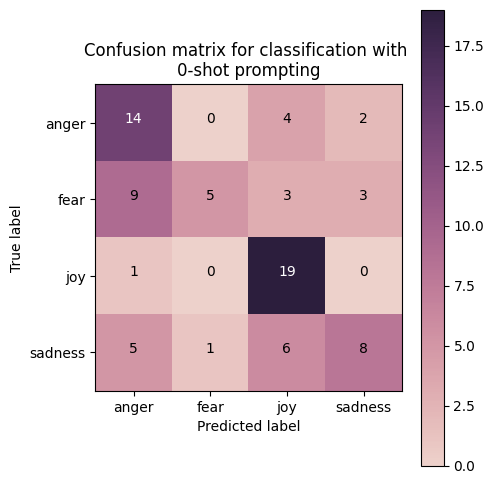

In [53]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with zero-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=0)


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    

Examples: 
Text: @m_warner21 Yikes. The wrath of Maddie...
Class: anger

Text: @falklands_utd @mauriciomacri \nbecause distrust in life , Argentina has a lot of heart and this President is worth every vote.
Class: fear

Text: Omg. You've got to watch the new series 'This is Us'.....wow. Best tv show I've seen in a long time.\n#tears #laughter #moretears
Class: joy

Text: It's a gloomy ass day
Class: sadness




Processing samples for emotion: anger...:  55%|█████▌    | 11/20 [00:07<00:06,  1.37it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 13.572268429s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:56<00:27,  5.49s/it]

Rate limit of 15 requests per minute reached. Waiting for 3.97 seconds.


Processing samples for emotion: fear...:  35%|███▌      | 7/20 [00:05<00:09,  1.33it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 12.672158164s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:37<00:53,  5.35s/it]

Rate limit of 15 requests per minute reached. Waiting for 18.92 seconds.


Processing samples for emotion: joy...:  15%|█▌        | 3/20 [00:02<00:16,  1.05it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 10.679561141s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions':

Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:34<02:05,  8.36s/it]

Rate limit of 15 requests per minute reached. Waiting for 18.20 seconds.


Processing samples for emotion: joy...:  95%|█████████▌| 19/20 [01:03<00:00,  1.28it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 9.792541585s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': 

Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 17.84 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [00:29<00:03,  1.35it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.90 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Results saved to ./results/llm_classification_results/results_samples_20_shots_1.csv
Accuracy: 62.50%
              precision    recall  f1-score   support

       anger       0.48      0.75      0.59        20
        fear       0.86      0.30      0.44        20
         joy       0.70      0.95      0.81        20
     sadness       0.67      0.50      0.57        20

    accuracy                           0.62        80
   macro avg       0.68      0.62      0.60        80
weighted avg       0.68      0.62      0.60        80



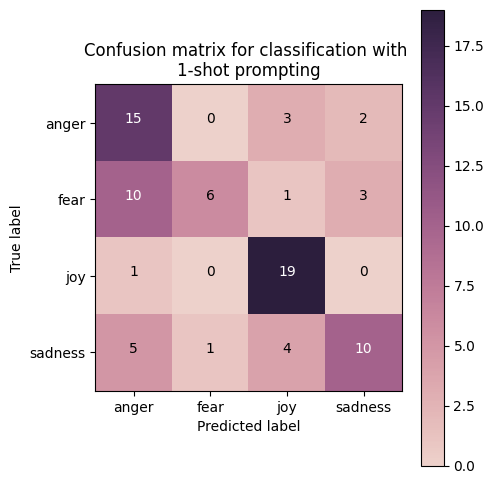

In [54]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 1-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=1)


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    

Examples: 
Text: @m_warner21 Yikes. The wrath of Maddie...
Class: anger

Text: LVG bribed all the refs against Utd for his own personal revenge. That was a foul you prick.
Class: anger

Text: and naoto nod she also like tha bands. but she also frown. 'Will the bands 'Papa Roach' be at concert...?'
Class: anger

Text: In 2016, Black people are STILL fighting to be recognized as human beings. #cantsleep #angry
Class: anger

Text: Spurs radio commentator referred to Mauricio Pochettino as 'MoPo' and I felt a sudden surge of rage.
Class: anger

Text: @falklands_utd @mauriciomacri \nbecause distrust in life , Argentina has a lot of heart and this President is worth every vote.
Class: fear

Text: induction day tomorrow for pizza express 
Class: fear

Text: @ExpressScripts u shd b embrrssd. u jack up my bp meds tw

Processing samples for emotion: anger...:  55%|█████▌    | 11/20 [00:08<00:07,  1.28it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 8.280496007s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': 

Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:41<00:19,  3.83s/it]

Rate limit of 15 requests per minute reached. Waiting for 18.48 seconds.


Processing samples for emotion: fear...:  35%|███▌      | 7/20 [00:07<00:11,  1.10it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 4.906861938s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': 

Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:40<00:54,  5.42s/it]

Rate limit of 15 requests per minute reached. Waiting for 15.29 seconds.


Processing samples for emotion: joy...:  15%|█▌        | 3/20 [00:02<00:14,  1.18it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 6.795012826s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': 

Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:34<02:07,  8.53s/it]

Rate limit of 15 requests per minute reached. Waiting for 17.84 seconds.


Processing samples for emotion: joy...:  95%|█████████▌| 19/20 [01:03<00:00,  1.14it/s]

Error occurred when generating response, error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.5-flash-lite\nPlease retry in 5.56972668s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {

Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 17.67 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [00:29<00:04,  1.24it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.79 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


Results saved to ./results/llm_classification_results/results_samples_20_shots_5.csv
Accuracy: 60.00%
              precision    recall  f1-score   support

       anger       0.48      0.65      0.55        20
        fear       0.86      0.30      0.44        20
         joy       0.63      0.85      0.72        20
     sadness       0.63      0.60      0.62        20

    accuracy                           0.60        80
   macro avg       0.65      0.60      0.58        80
weighted avg       0.65      0.60      0.58        80



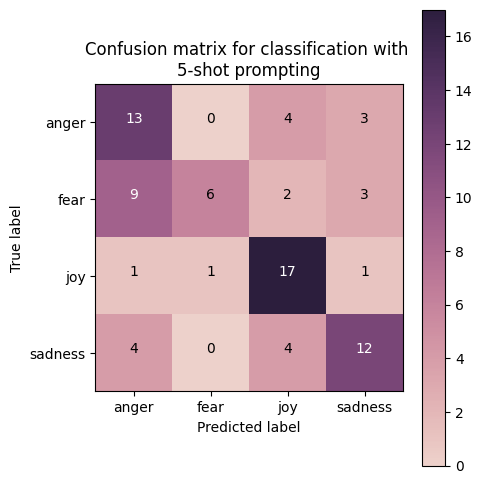

In [55]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 5-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=5)

---
##### <a id='toc1_5_10_1_1_'></a>[**>>> Exercise 6 (Take home):**](#toc0_)

Compare and discuss the overall results of the zero-shot, 1-shot and 5-shot classification.

In [ ]:
# Answer here
# All methods yield about 60% accuracy, with one-shot being sligthly the best. This is however not a very good score for this task. In many samples,
# the context has not been found out be the LLM and it gets wrongly classified. This is especially hard for i.e. sarcasm and jokes, where the literal words mean 
# something else than the subtext. 


---
##### <a id='toc1_5_10_1_2_'></a>[**>>> Exercise 7 (Take home):**](#toc0_)

**Case Study:** Check the results' files inside the `results/llm_classification_results` directory and find cases where the **text classification improves with more examples** (pred emotion is right with examples), **cases where it does not improve** (pred emotion always wrong) and **cases where the classification got worse with more examples** (pred emotion goes from right to wrong with examples). For this you need to load the results with pandas and handle the data using its dataframe functions. Discuss about the findings.

In [62]:
import pandas as pd
import os
from glob import glob
pd.set_option('display.max_colwidth', None)


# Path to the directory containing your datasets
data_dir = "./results/llm_classification_results"

# Find all CSV files in the directory
csv_files = glob(os.path.join(data_dir, "*.csv"))

# Load each CSV into a DataFrame
dfs = [pd.read_csv(f) for f in csv_files]

# Optionally, assign them to variables if you know there are exactly three files
df1, df2, df3 = dfs

# Loop through all indices assuming the DataFrames are aligned by row
found = [False, False, False]  # track which df has a found example

# Loop through all indices assuming the DataFrames are aligned by row
for idx in range(23, len(df1)):
    correct = [dfs[i].loc[idx, 'true_emotion'] == dfs[i].loc[idx, 'predicted_emotion'] for i in range(3)]
    
    if correct.count(True) == 1:
        correct_df_idx = correct.index(True)
        if not found[correct_df_idx]:
            print(f"Row index {idx}: Correct only in df{correct_df_idx+1}")
            print("Text:", dfs[correct_df_idx].loc[idx, 'text'])
            print("Predictions:")
            for i in range(3):
                status = "✔️ correct" if correct[i] else "❌ wrong"
                print(f"  df{i+1}: {dfs[i].loc[idx, 'predicted_emotion']} ({status})")
            print("\n---\n")
            found[correct_df_idx] = True
    
    if all(found):
        break




Row index 37: Correct only in df2
Text: #Awareness seek #shelter .#Letgo Old #habit of chasing #desires resultin in #anger #fear #worry .#Choose #Satisfaction within #Peace #Relax
Predictions:
  df1: anger (❌ wrong)
  df2: fear (✔️ correct)
  df3: anger (❌ wrong)

---

Row index 75: Correct only in df3
Text: [ @HedgehogDylan ] *she would frown a bit, folding her arms* 'why is it that every time I'm in need of assistance someone expects a lil **
Predictions:
  df1: anger (❌ wrong)
  df2: anger (❌ wrong)
  df3: sadness (✔️ correct)

---



### Findings:
Zero shot has no instance which gets classified correct while the others dont. It is the worst performing method out of the three, so this makes sense.

The one-shot method has an instance, which is # 37. With all the hashtags, the traditional text structure of the additional examples in the prompt might be confusing to the LLM, since this structure is so much different. 

The example from the few-shot method has a speech, where the context might be anger or sadness. But the word frowning is probably why it got classified as sadness, not very clear. Still, in this instance it was apparently better to have more examples in the prompt.


---
### <a id='toc1_5_11_'></a>[**2.7 Extra LLM Related Materials:**](#toc0_)
So this will be it for the lab, but here are some extra materials if you would like to explore:

- **How to use OpenAI ChatGPT model's API (Not Free API):** [Basics Video](https://www.youtube.com/watch?v=e9P7FLi5Zy8), [Basics GitHub](https://github.com/gkamradt/langchain-tutorials/blob/main/chatapi/ChatAPI%20%2B%20LangChain%20Basics.ipynb), [RAG's Basics Video](https://www.youtube.com/watch?v=9AXP7tCI9PI&t=300s), [RAG's Basics GitHub](https://github.com/techleadhd/chatgpt-retrieval)

- **Advanced topic - QLoRA (Quantized Low-Rank Adapter):** QLoRA is a method used to make fine-tuning large language models more efficient. It works by adding a small, trainable part (LoRA) to a pre-trained model, while keeping the rest of the model frozen. At the same time, it reduces the size of the model’s data using a process called quantization, which makes the model require less memory. This allows you to fine-tune large models without needing as much computational power, making it easier to adapt models for specific tasks. Materials: [Paper GitHub](https://github.com/artidoro/qlora?tab=readme-ov-file), [Llama 3 Application Video](https://www.youtube.com/watch?v=YJNbgusTSF0&t=512s),[Llama 3 Application GitHub](https://github.com/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb)

- **How to Fine-tune and run local LLMs with the `unsloth` library:** [unsloth tutorials](https://docs.unsloth.ai/models/tutorials-how-to-fine-tune-and-run-llms)

- **Google's Agent Development Kit Documentation:** [ADK](https://google.github.io/adk-docs/)

- **Build AI agents with LangGraph:** [LangGraph Documentation](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/)

---